# Kaggle Titanic Survivor Challenge Submission

## Using different data wrangling and machine learning techniques, this notebook aims to score the highest possible score on the [Titanic Kaggle Challenge](https://www.kaggle.com/c/titanic)

This notebook uses following libraries:
* pandas        - management of the passenger data
* numpy         - fast calculations
* matplotlib    - visualization of the data
* seaborn       - used in combination with seaborn
* scikit-learn  - contains the machine learning models we are using


## First, we need to load the necessary libraries, training data and test data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
df_train = pd.read_csv('data/train.csv', sep=",")
df_test = pd.read_csv('data/test.csv', sep=",")

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Feature Engineering

Show which columns contain NaN

In [4]:
pd.concat([pd.Series(df_train.isnull().sum(), name="train"), pd.Series(df_test.isnull().sum(), name="test")], axis=1)

,train,test
PassengerId,0,0.0
Survived,0,NaN
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,177,86.0
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0
Fare,0,1.0


Let's check which pessengers have no age value:

In [5]:
df_age_nan = df_train.loc[df_train["Age"].isna()]
df_age_nan.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q


There are many ways to fill the missing age values, the simplest being filling in the mean age of all passengers.
We will fill in the median age of certain person groups which will be defined by sex, class and number of relatives.  

First, we turn the "male" and "female" values into integers.

In [6]:
dataframes = (df_train, df_test)
for df in dataframes:
    df_temp = pd.get_dummies(df, prefix=['Sex'], columns = ['Sex'], drop_first=True)
    df["Sex"] = df_temp["Sex_male"]


In [7]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S


Let's check the number of unique passenger classes and amount of relatives.  
The number of relatives is defined by the number of parents/children ("Parch") and the number of siblings/spouses ("SibSp")

In [8]:
print("Pclass", df_train["Pclass"].unique())
print("Parch", df_train["Parch"].unique())
print("SibSp", df_train["SibSp"].unique())

Pclass [3 1 2]
Parch [0 1 2 5 3 4 6]
SibSp [1 0 3 4 2 5 8]


Next, we bin the number of relatives.  
First parents/children, then siblings/spouses

In [9]:
from sklearn.preprocessing import FunctionTransformer, KBinsDiscretizer

In [10]:
parch_bins = [0, 1, 2, np.inf]
parch_labels = ["1", "2", "4"]

sib_bins = [0, 1, 2, np.inf]
sib_labels = ["1", "2", "4"]

for df in dataframes:
    parch_binner = FunctionTransformer(pd.cut, kw_args={"bins": parch_bins, "labels": parch_labels, "retbins": False})
    parch_binned = parch_binner.fit_transform(df["Parch"].values)
    df["Parch"] = parch_binned.tolist()
    df["Parch"].fillna(0, inplace=True)

    sib_binner = FunctionTransformer(pd.cut, kw_args={"bins": sib_bins, "labels": sib_labels, "retbins": False})
    sib_binned = sib_binner.fit_transform(df["SibSp"].values)
    df["SibSp"] = sib_binned.tolist()
    df["SibSp"].fillna(0, inplace=True)
    

In [11]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S


Now, we impute the missing age values with the age medians of the corresponding passenger groups.

In [12]:
for df in dataframes:
    age_group = df.groupby(["Parch", "SibSp", "Pclass"])['Age'].agg(["median"]).round(1)
    for row, value in df.loc[df["Age"].isnull()]["Age"].iteritems():
        df.loc[row, "Age"] = age_group.loc[df.loc[row]["Parch"], df.loc[row]["SibSp"], df.loc[row]["Pclass"]]["median"]
        df["Age"].fillna(df["Age"].median(), inplace=True)

    binner = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='uniform')
    binner.fit(df[['Age']])
    df["Age_bin"] = binner.transform(df[['Age']])

In [13]:
df_train.groupby("Age_bin")["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
Age_bin,,,,,,,,
0.0,84.0,5.561548,3.713029,0.42,2.00,5.0,9.0,13.5
1.0,371.0,22.479784,3.567344,14.00,19.00,24.0,26.0,26.0
2.0,286.0,33.167832,4.006549,27.00,30.00,33.0,36.0,40.0
3.0,100.0,46.240000,3.489146,40.50,43.00,46.0,49.0,53.0
4.0,43.0,58.825581,3.725529,54.00,55.75,58.0,62.0,66.0
5.0,7.0,72.357143,3.636783,70.00,70.25,71.0,72.5,80.0


In [14]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_bin
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,2.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,2.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,2.0


In [15]:
for row, item in df_age_nan["Age"].iteritems():
    df_train.loc[row, "Age"] = df_train[(df_train["Parch"] == df_train.loc[row, "Parch"]) & (df_train["SibSp"] == df_train.loc[row, "SibSp"]) & (df_train["Pclass"] == df_train.loc[row, "Pclass"])]["Age"].dropna().median()

## Let's find out the titles aka social rank of the passengers.
First, we use regex to find the titles of the passengers

In [16]:
df_train['rank'] = df_train['Name'].str.split('([A-Za-z]+)(\.)', expand=True)[1]
df_train["rank"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

Then, we create an order for the titles, giving them a hierarchy.
We don't differentiate between male and female because we still have the "Sex" column.

In [17]:
for df in (df_train, df_test):
    df['rank'] = df['Name'].str.split('([A-Za-z]+)(\.)', expand=True)[1]
    titles = df["rank"].unique().tolist()
    rank = [0,0,0,2,2,1,1,0,0,2,2,0,0,2,2,2,2]
    dic = {}
    for title, rank in zip(titles, rank):
        dic[title] = rank
    df["rank"].replace(dic, inplace=True)
df_train = df_train.drop(columns=["Name"])
df_test = df_test.drop(columns=["Name"])

### Pipeline of OHE and Imputation for Embarked

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


In [19]:
impute_and_encode = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(sparse=False))

In [20]:
impute_and_encode.fit(df_train[["Embarked"]])
t = impute_and_encode.transform(df_train[["Embarked"]])
embarked_matrix = pd.DataFrame(t, columns=impute_and_encode[1].get_feature_names())
df_train = pd.concat([df_train, embarked_matrix], axis=1).drop(["Embarked"], axis=1)

In [21]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Age_bin          0
rank             0
x0_C             0
x0_Q             0
x0_S             0
dtype: int64

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import statistics

model = LogisticRegression(max_iter=1000)
accuracy = cross_val_score(model, df_train[["Pclass", "Fare", "rank"]], df_train["x0_Q"], cv=15, scoring='accuracy')
print("cross-validation scores", accuracy)
print("median of cross-validation scores", statistics.median(accuracy))

cross-validation scores [0.91666667 0.91666667 0.91666667 0.91666667 0.9        0.9
 0.91525424 0.91525424 0.91525424 0.91525424 0.91525424 0.91525424
 0.91525424 0.91525424 0.91525424]
median of cross-validation scores 0.9152542372881356


In [23]:
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Age_bin,rank,x0_C,x0_Q,x0_S
0,1,0,3,1,22.0,1,0,A/5 21171,7.2500,NaN,1.0,0,0.0,0.0,1.0
1,2,1,1,0,38.0,1,0,PC 17599,71.2833,C85,2.0,0,1.0,0.0,0.0
2,3,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1.0,0,0.0,0.0,1.0
3,4,1,1,0,35.0,1,0,113803,53.1000,C123,2.0,0,0.0,0.0,1.0
4,5,0,3,1,35.0,0,0,373450,8.0500,NaN,2.0,0,0.0,0.0,1.0


### Cabin

In [24]:
for df in (df_train, df_test):
    df["Cabin"] = df["Cabin"].fillna("Z")
    result = df["Cabin"].astype(str).str[0]
    df["deck"] = result.replace({"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 1, "Z": 3.5})
    df["cabin_number"] = df["Cabin"].str.split('([A-Za-z]+)(\d+)', expand=True)[2]

In [25]:
df_train["cabin_number"].unique()

array([None, '85', '123', '46', '6', '103', '56', '23', '78', '33', '30',
       '52', '28', '83', '73', '31', '5', '10', '26', '110', '58', '101',
       '69', '47', '86', '2', '19', '7', '49', '4', '32', '80', '36',
       '15', '93', '35', '87', '77', '67', '94', '125', '99', '118', '22',
       '106', '65', '54', '57', '34', '18', '124', '91', '40', '128',
       '37', '50', '82', '96', '44', '104', '111', '92', '38', '21', '12',
       '63', '14', '20', '79', '25', '95', '39', '70', '16', '68', '41',
       '9', '48', '126', '71', '51', '62', '24', '90', '45', '8', '121',
       '11', '3', '17', '102', '42', '148'], dtype=object)

In [26]:
for df in (df_train, df_test):
    for row, value in df.loc[df["cabin_number"].isna()]["Pclass"].iteritems():
        df.loc[row, "cabin_number"] = df[df["Pclass"] == df.loc[row, "Pclass"]]["cabin_number"].median()
#    df["cabin_number"] = df["cabin_number"].fillna(df["cabin_number"].median()).astype(int)
    print(df["cabin_number"])

0      50.5
1        85
2      50.5
3       123
4      50.5
       ... 
886    33.0
887      42
888    50.5
889     148
890    50.5
Name: cabin_number, Length: 891, dtype: object
0      51.5
1      51.5
2       4.0
3      51.5
4      51.5
       ... 
413    51.5
414     105
415    51.5
416    51.5
417    51.5
Name: cabin_number, Length: 418, dtype: object


In [27]:
df_train["cabin_number"].unique()

array([50.5, '85', '123', '46', 33.0, '6', '103', '56', '23', 44.0, '78',
       '33', '30', '52', '28', '83', '73', '31', '5', '10', '26', '110',
       '58', '101', '69', '47', '86', '2', '19', '7', '49', '4', '32',
       '80', '36', '15', '93', '35', '87', '77', '67', '94', '125', '99',
       '118', '22', '106', '65', '54', '57', '34', '18', '124', '91',
       '40', '128', '37', '50', '82', '96', '44', '104', '111', '92',
       '38', '21', '12', '63', '14', '20', '79', '25', '95', '39', '70',
       '16', '68', '41', '9', '48', '126', '71', '51', '62', '24', '90',
       '45', '8', '121', '11', '3', '17', '102', '42', '148'],
      dtype=object)

In [28]:
df_train["cabin_number"]

0      50.5
1        85
2      50.5
3       123
4      50.5
       ... 
886    33.0
887      42
888    50.5
889     148
890    50.5
Name: cabin_number, Length: 891, dtype: object

### Imputation and Binning for Age

In [29]:
from sklearn.impute import SimpleImputer
# imp_age = SimpleImputer(strategy="median")
# imp_age.fit(df[["Age"]])
# t = imp_age.transform(df[["Age"]])
# df["Age"] = t

In [30]:
# df["Age"] = df["Age"].fillna(df["Age"].median()).astype(int)
# df

In [31]:
df_train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Age_bin,rank,x0_C,x0_Q,x0_S,deck,cabin_number
0,1,0,3,1,22.0,1,0,A/5 21171,7.2500,Z,1.0,0,0.0,0.0,1.0,3.5,50.5
1,2,1,1,0,38.0,1,0,PC 17599,71.2833,C85,2.0,0,1.0,0.0,0.0,3.0,85
2,3,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,Z,1.0,0,0.0,0.0,1.0,3.5,50.5
3,4,1,1,0,35.0,1,0,113803,53.1000,C123,2.0,0,0.0,0.0,1.0,3.0,123
4,5,0,3,1,35.0,0,0,373450,8.0500,Z,2.0,0,0.0,0.0,1.0,3.5,50.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.0,0,0,211536,13.0000,Z,2.0,1,0.0,0.0,1.0,3.5,33.0
887,888,1,1,0,19.0,0,0,112053,30.0000,B42,1.0,0,0.0,0.0,1.0,2.0,42
888,889,0,3,0,13.5,1,2,W./C. 6607,23.4500,Z,0.0,0,0.0,0.0,1.0,3.5,50.5
889,890,1,1,1,26.0,0,0,111369,30.0000,C148,1.0,0,1.0,0.0,0.0,3.0,148


Scale Data

In [32]:
from sklearn.preprocessing import MinMaxScaler
for df in (df_train, df_test):
    x = df[["rank", "Age_bin", "cabin_number", "Pclass", "Fare", "Sex", "SibSp", "Parch"]].values #returns a numpy array
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.concat([df.drop(columns=["rank", "Age_bin", "cabin_number", "Pclass", "Fare", "Sex", "SibSp", "Parch"])], axis=1)

In [33]:
x = df_train[["rank", "Age_bin", "cabin_number", "Pclass", "Fare", "Sex", "SibSp", "Parch"]].values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_train = pd.concat([df_train.drop(["rank", "Age_bin", "cabin_number", "Pclass", "Fare", "Sex", "SibSp", "Parch"],
                                    axis=1),
                     pd.DataFrame(x_scaled, columns=["rank", "Age_bin", "cabin_number", "Pclass", "Fare", "Sex", "SibSp", "Parch"])],
                     axis=1)

In [34]:
x = df_test[["rank", "Age_bin", "cabin_number", "Pclass", "Fare", "Sex", "SibSp", "Parch"]].values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_test = pd.concat([df_test.drop(["rank", "Age_bin", "cabin_number", "Pclass", "Fare", "Sex", "SibSp", "Parch"], axis=1),
                     pd.DataFrame(x_scaled, columns=["rank", "Age_bin", "cabin_number", "Pclass", "Fare", "Sex", "SibSp", "Parch"])], axis=1)

In [37]:
# Split the DataFrame into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X_train = df_train[["rank", "Age_bin", "cabin_number", "Pclass", "Fare", "Sex", "SibSp", "Parch"]]
y_train = df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=42, train_size=0.65, test_size=0.35)
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
print("train accuracy:", model.score(X_train, y_train))
print("test accuracy:", model.score(X_test, y_test))

train accuracy: 0.8255613126079447
test accuracy: 0.8108974358974359


In [38]:
df_train

,PassengerId,Survived,Age,Ticket,Cabin,x0_C,x0_Q,x0_S,deck,rank,Age_bin,cabin_number,Pclass,Fare,Sex,SibSp,Parch
0,1,0,22.0,A/5 21171,Z,0.0,0.0,1.0,3.5,0.0,0.2,0.332192,1.0,0.014151,1.0,0.25,0.0
1,2,1,38.0,PC 17599,C85,1.0,0.0,0.0,3.0,0.0,0.4,0.568493,0.0,0.139136,0.0,0.25,0.0
2,3,1,26.0,STON/O2. 3101282,Z,0.0,0.0,1.0,3.5,0.0,0.2,0.332192,1.0,0.015469,0.0,0.00,0.0
3,4,1,35.0,113803,C123,0.0,0.0,1.0,3.0,0.0,0.4,0.828767,0.0,0.103644,0.0,0.25,0.0
4,5,0,35.0,373450,Z,0.0,0.0,1.0,3.5,0.0,0.4,0.332192,1.0,0.015713,1.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,27.0,211536,Z,0.0,0.0,1.0,3.5,0.5,0.4,0.212329,0.5,0.025374,1.0,0.00,0.0
887,888,1,19.0,112053,B42,0.0,0.0,1.0,2.0,0.0,0.2,0.273973,0.0,0.058556,0.0,0.00,0.0
888,889,0,13.5,W./C. 6607,Z,0.0,0.0,1.0,3.5,0.0,0.0,0.332192,1.0,0.045771,0.0,0.25,0.5
889,890,1,26.0,111369,C148,1.0,0.0,0.0,3.0,0.0,0.2,1.000000,0.0,0.058556,1.0,0.00,0.0


# Defining the Feature Matrix and the Target Vector

In [39]:
# X = df[["Pclass", "Age", "SibSp", "Parch", "Sex_male", "Fare", "x0_C", "x0_Q", "x0_S"]]
X_train = df_train[["rank", "Age_bin", "cabin_number", "Pclass", "Fare", "Sex", "SibSp", "Parch"]]
y_train = df_train['Survived']
X_test = df_test[["rank", "Age_bin", "cabin_number", "Pclass", "Fare", "Sex", "SibSp", "Parch"]]
# y_test = df_test['Survived']

In [40]:
X_train.isnull().sum()

rank            0
Age_bin         0
cabin_number    0
Pclass          0
Fare            0
Sex             0
SibSp           0
Parch           0
dtype: int64

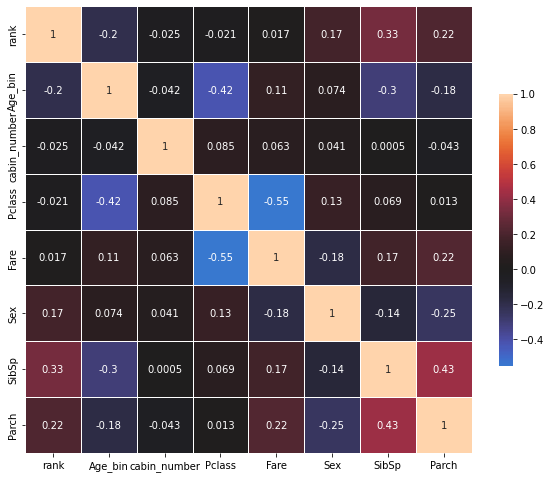

In [41]:
plt.figure(figsize=(10, 10))
sns.heatmap(X_train.corr(), center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.savefig("titanic_corr.png", dpi=150, format="png")

In [42]:
# Split the DataFrame into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=42, train_size=0.65, test_size=0.35)

In [43]:
X_train.describe()

,rank,Age_bin,cabin_number,Pclass,Fare,Sex,SibSp,Parch
count,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000
mean,0.060449,0.323661,0.304865,0.671848,0.062421,0.651123,0.135579,0.093696
std,0.231156,0.204896,0.121724,0.411031,0.101701,0.477027,0.258027,0.196661
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.200000,0.212329,0.500000,0.015412,0.000000,0.000000,0.000000
50%,0.000000,0.200000,0.332192,1.000000,0.028107,1.000000,0.000000,0.000000
75%,0.000000,0.400000,0.332192,1.000000,0.060020,1.000000,0.250000,0.000000
max,1.000000,1.000000,0.863014,1.000000,1.000000,1.000000,1.000000,1.000000


# Performing the Logistic Regression

In [44]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : (0.1, 1, 10, 100),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000, 2500, 5000]
    }
]

In [45]:
from sklearn.model_selection import GridSearchCV
model = LogisticRegression()
clf = GridSearchCV(model, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train,y_train)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


/home/michael/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/michael/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michael/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/michael/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/michael/anaconda3/lib/pytho

In [46]:
best_clf.best_estimator_

LogisticRegression(C=1)

In [47]:
print (f'Accuracy - : {best_clf.score(X_test,y_test):.3f}')

Accuracy - : 0.811


In [48]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l2', C=10, random_state=42)
model.fit(X_train, y_train)
print("train accuracy:", model.score(X_train, y_train))
print("test accuracy:", model.score(X_test, y_test))

train accuracy: 0.8272884283246977
test accuracy: 0.8141025641025641


# 3. Evaluate your model

## 3.1. Accuracy, Precision, Recall, F1, DummyClassifiers

In [49]:
from sklearn.metrics import accuracy_score
accuracy_score(model.predict(X_test), y_test)

0.8141025641025641

In [50]:
from sklearn.metrics import precision_score
precision_score(model.predict(X_test), y_test)

0.75

In [51]:
from sklearn.metrics import recall_score
recall_score(model.predict(X_test), y_test)

0.775

In [52]:
from sklearn.metrics import f1_score
f1_score(model.predict(X_test), y_test)

0.7622950819672132

In [53]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(model.predict(X_train), y_train)
accuracy_score(dummy_clf.predict(X_test), y_test)

0.6025641025641025

In [54]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(model.predict(X_train), y_train)
accuracy_score(dummy_clf.predict(X_test), y_test)

0.5192307692307693

In [55]:
dummy_clf = DummyClassifier(strategy='uniform')
dummy_clf.fit(model.predict(X_train), y_train)
accuracy_score(dummy_clf.predict(X_test), y_test)

0.46474358974358976

## 3.2. ROC-Curve

In [56]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
lr_probs = model.predict_proba(X_test)[:, 1]

In [57]:
ns_probs = [0 for y in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)

In [58]:
lr_auc = roc_auc_score(y_test, lr_probs)

In [59]:
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.882


In [60]:
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

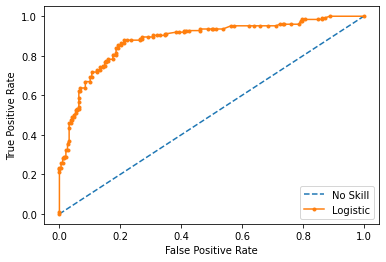

In [61]:
from matplotlib import pyplot
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## 3.3. Precision Recall Curve

In [58]:
from sklearn.metrics import precision_recall_curve
yhat = model.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[1])
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

ValueError: Found input variables with inconsistent numbers of samples: [312, 2]

## 3.4. Decision Boundary
Plot the decision boundary for two scalar features from the Titanic dataset. Use this code example:

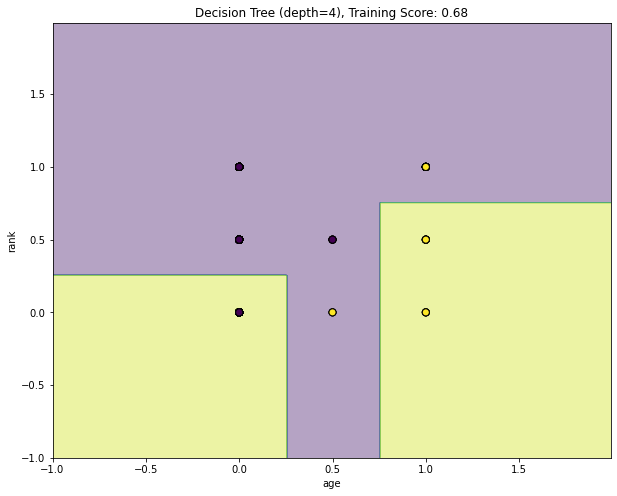

In [62]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier

X2 = X_train.iloc[:,[0,3]].values
# Train a classification model
m = DecisionTreeClassifier(max_depth=4)
m.fit(X2, y_train)
# What about other models? Try them here as well.

#step size in the mesh
h = 0.01

# Plotting decision regions
#For that, we will assign a color to each point in the mesh [x_min, x_max] * [y_min, y_max]
x_min, x_max = X2[:][:, 0].min() - 1, X2[:][:, 0].max() + 1
y_min, y_max = X2[:][:, 1].min() - 1, X2[:][:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

f, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 8))

Xgrid = np.c_[xx.ravel(), yy.ravel()]
Z = m.predict(Xgrid)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, alpha=0.4)

#plot the training points
ax.scatter(X2[:, 0], X2[:, 1], c=y_train, s=50, edgecolor='k')
ax.set_title(f'Decision Tree (depth=4), Training Score: {round(m.score(X2, y_train), 2)}')
plt.xlabel('age')
plt.ylabel('rank')

plt.show()


# 5. Cross-validation Score

In [63]:
from sklearn.model_selection import cross_val_score
import statistics

model = LogisticRegression()
accuracy = cross_val_score(model, X_train, y_train, cv=15, scoring='accuracy')
print("cross-validation scores", accuracy)
print("median of cross-validation scores", statistics.median(accuracy))

cross-validation scores [0.76923077 0.74358974 0.92307692 0.92307692 0.82051282 0.84615385
 0.82051282 0.74358974 0.69230769 0.84210526 0.84210526 0.78947368
 0.76315789 0.92105263 0.86842105]
median of cross-validation scores 0.8205128205128205


# 6. Random Forest

## 6.1. Random Forest

In [64]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(criterion="entropy", n_estimators=1000, max_features='log2', max_depth=9, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [65]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[168,  20],
       [ 39,  85]])

## Random Forest Optimization

In [66]:
n_est = [500, 800, 1500, 2000]
max_feat = ["auto", "sqrt", "log2"]
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
max_depth.append(None)
min_samples_split = [2, 3, 4, 10]
min_samples_leaf = [1, 2, 5, 10]

In [67]:
grid_param = {"n_estimators": n_est,
           "max_features": max_feat,
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "min_samples_leaf": min_samples_leaf  
           }

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
clf = RandomForestClassifier(random_state=42)
clf_random = RandomizedSearchCV(estimator=clf, param_distributions=grid_param, n_iter=500, cv=2, verbose=2, random_state=42, n_jobs=-1)
clf_random.fit(X_train, y_train)
print(clf_random.best_params_)

Fitting 2 folds for each of 500 candidates, totalling 1000 fits
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=1500; total time=   3.1s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=1500; total time=   3.2s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=1500; total time=   3.3s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=1500; total time=   3.3s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=2000; total time=   4.5s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=2000; total time=   4.6s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=2000; total time=   4.6s
[CV] END max_depth=1, max_features=auto, min_samples_leaf=10, min_samples_split=4, n_e

In [66]:
y_pred = clf_random.predict(X_test)
accuracy = clf_random.score(X_test, y_test)
print(accuracy)

0.8044871794871795


## 6.3. Ensemble Model

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

models = [('logreg', LogisticRegression(penalty='l2', C=1, max_iter=1000, random_state=42)),
          ("forest", RandomForestClassifier(criterion="entropy", n_estimators=2000, min_samples_split=10,
                                            min_samples_leaf=2, max_features="log2", max_depth=10,
                                            random_state=42)),
          ('svm', SVC(kernel='rbf', C=1, probability=True, random_state=42)),
          ]
m = VotingClassifier(models, n_jobs=-1, voting="hard")

m.fit(X_train, y_train)
ypreds = m.predict(X_test)
# m.score(X_test, y_test)

In [77]:
ypreds.transpose()

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,

In [79]:
ypreds_df = pd.DataFrame(data=ypreds.transpose(), columns=["Survived"])
ypreds_df

,Survived
0,1
1,0
2,0
3,1
4,1
...,...
307,1
308,1
309,0
310,0


In [86]:
df_test.shape

(418, 14)

In [80]:
survivor_prediction_submission = pd.DataFrame(df_test["PassengerId"]).join(ypreds_df)

In [83]:
survivor_prediction_submission[survivor_prediction_submission["Survived"].isna()==False].astype(int)

,PassengerId,Survived
0,892,1
1,893,0
2,894,0
3,895,1
4,896,1
...,...,...
307,1199,1
308,1200,1
309,1201,0
310,1202,0


In [84]:
survivor_prediction_submission

,PassengerId,Survived
0,892,1.0
1,893,0.0
2,894,0.0
3,895,1.0
4,896,1.0
...,...,...
413,1305,NaN
414,1306,NaN
415,1307,NaN
416,1308,NaN


In [73]:
survivor_prediction_submission.to_csv("survivor_prediction_submission.csv", index=False)